# Lab Assigment 2 Estimation of Apparent Motion

<p style="text-align:left;">
    José Pedro Cruz
    <span style="float:right;">
        up201504646
    </span>
</p>
<p style="text-align:left;">
    Martinho Figueiredo
    <span style="float:right;">
        up201506179
    </span>
</p>
<p style="text-align:left;">
    Nuno Nascimento
    <span style="float:right;">
        up201907933
    </span>
</p>


[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/martinhofigueiredo/VC)



## Scheme
```mermaid
flowchart LR
    A[Ingest Footage] -->|mp4 or mpegs| B{Multi Channel?}
    B -->|Yes| C[Split into Channels]
    B -->|No| D[Gray]-->H
    C --> E[R]-->H
    C --> F[G]-->H
    C --> G[B]-->H
    H{Multi Resolution?}-->|Yes|I[n Pyramid DownSampling Average]-->K
    H-->|No|J[One Shot]-->K
    K{algo} -->|HornShunck| M((.flo file))
    K -->|LucasKanade| M
```


## Benchmarking

```mermaid
flowchart LR
    GT[Ground truth] --> B{BenchMark}
    A(Flow Calculated) --> B
    B --> AE(Angular Error and Std Dev)
    B --> EE(Endpoint Error and Std Dev)
```


## Visualization
```mermaid
flowchart LR
    A[import .flo file]-->C{Type}
    C-->VF[Vector Field]
    C-->MF[Middlebury Flow]
    
```

# Setup

In [56]:
import cv2
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from scipy.ndimage.filters import convolve as filter2
import struct
import argparse
import math
%matplotlib widget


C:\Users\nmcna\AppData\Local\Temp\ipykernel_15680\130197631.py:7: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve as filter2


## Import Dataset

In [4]:
# IMport dataset with public ground truth
%pip install wget
import os
import subprocess
import wget
import zipfile

# Specify the URLs of the files to download
url1 = "https://vision.middlebury.edu/flow/data/comp/zip/other-gt-flow.zip"
url2 = "https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip"
url3 = "https://vision.middlebury.edu/flow/data/comp/zip/eval-color-allframes.zip"
# Specify the destination folder to store the downloaded files
destination_folder = "dataset/"

# Download the files using wget
file1 = wget.download(url1, out=destination_folder)
file2 = wget.download(url2, out=destination_folder)
file3 = wget.download(url3, out=destination_folder)

# Unzip the files
with zipfile.ZipFile(file1, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

with zipfile.ZipFile(file2, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
    
with zipfile.ZipFile(file3, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

# Remove the zip files if needed
os.remove(file1)
os.remove(file2)
os.remove(file3)

Note: you may need to restart the kernel to use updated packages.


## Ingest 

In [57]:
# Find all jpgs and pngs in a folder and returns a list of their respective path 
def get_frame_paths(folder_path):
    frame_paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            frame_path = os.path.join(folder_path, filename)
            frame_paths.append(frame_path)
    frame_paths.sort()
    ##print(frame_paths)
    return frame_paths

In [58]:
# Checks if the inut file is a directory and if it is it will try and get the frames inside the folder
# it will check if it is and mp4 and if it is it will read it and create a list of frames
def get_input_frames(input_path):
    frames = []
    if os.path.isdir(input_path):
        frame_paths = get_frame_paths(input_path)
        #print(f"{frame_paths}")
        frames = [cv2.imread(frame_path) for frame_path in frame_paths]
    else :
        #print("here")
        if input_path.endswith('.mp4') or input_path.endswith('.mov') :
            cap = cv2.VideoCapture(input_path)
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                frames.append(frame)
            cap.release()
    return frames

## Load Algo Config from file

In [59]:
# Loads a yaml file with the parameters to run the code
def load_config(filename):
    with open(filename, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
        config['input_path']= os.getcwd()+config['input_path'] # Fix to run in the location it called
        #print(config)
    return config

## Flo file format Aux Functions

In [19]:
""" import struct

def write_flow_field(flow, filename):
    height, width, _ = flow.shape
    with open(filename, 'wb') as f:
        # Write the magic number: 'PIEH' in ASCII
        f.write(b'PIEH')

        # Write the width and height of the flow field
        f.write(np.array(width).astype(np.int32).tobytes())
        f.write(np.array(height).astype(np.int32).tobytes())

        # Interleave the u and v values and write the flow field data
        flow_data = np.concatenate((flow[..., 0], flow[..., 1]), axis=1)
        f.write(flow_data.astype(np.float32).tobytes())

def read_flow_field(filename):
    with open(filename, 'rb') as f:
        # Read the magic number
        magic = f.read(4).decode()
        if magic != 'PIEH':
            raise ValueError('Invalid flow file format.')

        # Read the width and height of the flow field
        width = np.frombuffer(f.read(4), dtype=np.int32)[0]
        height = np.frombuffer(f.read(4), dtype=np.int32)[0]

        # Read the flow field data
        flow_data = np.frombuffer(f.read(), dtype=np.float32)
        flow = flow_data.reshape((height, width, 2))

    return flow
 """

" import struct\n\ndef write_flow_field(flow, filename):\n    height, width, _ = flow.shape\n    with open(filename, 'wb') as f:\n        # Write the magic number: 'PIEH' in ASCII\n        f.write(b'PIEH')\n\n        # Write the width and height of the flow field\n        f.write(np.array(width).astype(np.int32).tobytes())\n        f.write(np.array(height).astype(np.int32).tobytes())\n\n        # Interleave the u and v values and write the flow field data\n        flow_data = np.concatenate((flow[..., 0], flow[..., 1]), axis=1)\n        f.write(flow_data.astype(np.float32).tobytes())\n\ndef read_flow_field(filename):\n    with open(filename, 'rb') as f:\n        # Read the magic number\n        magic = f.read(4).decode()\n        if magic != 'PIEH':\n            raise ValueError('Invalid flow file format.')\n\n        # Read the width and height of the flow field\n        width = np.frombuffer(f.read(4), dtype=np.int32)[0]\n        height = np.frombuffer(f.read(4), dtype=np.int32)[0]\n

In [60]:
import struct
import numpy as np


def read_flow_field(file_path):
    with open(file_path, "rb") as f:
        # Read .flo header
        magic = struct.unpack('f', f.read(4))[0]
        width = struct.unpack('i', f.read(4))[0]
        height = struct.unpack('i', f.read(4))[0]

        # Ensure .flo file format
        assert magic == 202021.25, "Invalid .flo file format."

        # Read optical flow data
        flow_data = np.fromfile(f, np.float32, width * height * 2)
        flow_data = flow_data.reshape((height, width, 2))

    return flow_data


def write_flow_field(file_path, flow_data):
    height, width = flow_data.shape[:2]
    with open(file_path, "wb") as f:
        # Write .flo header
        f.write(struct.pack('f', 202021.25))
        f.write(struct.pack('i', width))
        f.write(struct.pack('i', height))

        # Write optical flow data
        flow_data.flatten().astype(np.float32).tofile(f)

In [61]:
def calculate_angular_error(flow_gt, flow_pred):
    flow_gt_norm = np.sqrt(np.sum(flow_gt ** 2, axis=2))
    flow_pred_norm = np.sqrt(np.sum(flow_pred ** 2, axis=2))
    dot_product = np.sum(flow_gt * flow_pred, axis=2)
    cos_theta = np.clip(dot_product / (flow_gt_norm * flow_pred_norm), -1.0, 1.0)
    angular_error = np.arccos(cos_theta)
    return angular_error

def calculate_endpoint_error(flow_gt, flow_pred):
    endpoint_error = np.sqrt(np.sum((flow_gt - flow_pred) ** 2, axis=2))
    return endpoint_error


def calculate_error_statistics(error):
    mean_error = np.mean(error)
    std_error = np.std(error)
    return mean_error, std_error




In [ ]:
# Example usage
original_file = "/workspace/VC/assignment2/dataset/other-gt-flow/Urban2/flow10.flo"
new_file = "new.flo"

# Read the original .flo file
original_flow = read_flow_field(original_file)

# Write the original flow to a new .flo file
write_flow_field(new_file, original_flow)

# Read the new .flo file
new_flow = read_flow_field(new_file)

#Sanity check for write and read function

# Compare the original and new flow files
identical = np.array_equal(original_flow, new_flow)
print("The original and new files are identical:", identical)

angular_error = calculate_angular_error(original_flow, new_flow)
angular_mean, angular_std = calculate_error_statistics(angular_error)

#print('Mean Angular Error:', angular_mean)
#print('Standard Deviation of Angular Error:', angular_std)

endpoint_error = calculate_endpoint_error(original_flow, new_flow)
endpoint_mean, endpoint_std = calculate_error_statistics(endpoint_error)

print('Mean Endpoint Error:', endpoint_mean)
print('Standard Deviation of Endpoint Error:', endpoint_std)
os.remove(new_file)


# Lucas-Kanade

In [62]:
#print(f"Loading File \'config_LK.yml\'")

config = load_config('config_LK.yml')

input_path = config['input_path']

frames = get_input_frames(config['input_path'])

feature_params = dict(
    maxCorners=config['max_corners'],
    qualityLevel=config['quality_level'],
    minDistance=config['min_distance'],
    blockSize=config['block_size']
)
lk_params = dict(
    winSize=(config['window_size'], config['window_size']),
    maxLevel=config['max_level'],
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, config['max_iterations'], config['epsilon'])
)
color = np.random.randint(0, 255, (100, 3))
old_frame = frames[0]
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

mask = np.zeros_like(old_frame)
height, width, channels = old_frame.shape
mask_flow = np.zeros((height,width,2))
#print("DIM: ", mask_flow.shape)

for frame_num in frames[1:]:
    
    current_frame = frame_num
    frame_gray = cv2.cvtColor(frame_num, cv2.COLOR_BGR2GRAY)
    
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    #print("p1: ", np.asarray(p1).shape)
    #print(np.asarray(p1).shape)
    #print(p1)
    if p1 is not None:
        
        good_new = p1[st==1]
        good_old = p0[st==1]
    
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        
    frame_with_flow = cv2.add(current_frame, mask)
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

if os.path.isfile(input_path):
    file_name, file_extension = os.path.splitext(input_path)
    if file_extension.lower() not in ['.png', '.jpg']:
        #print("File name without extension:", os.path.basename(file_name))
        cv2.imwrite(file_name+'_flow.png', frame_with_flow)
        write_flow_field(file_name+'_flow_field.flo',mask)
    else:
        print("The file extension is .png or .jpg")
else:
    directory = input_path.split('dataset\\')[1].split('\\')
    #print("Directory after 'dataset\\':", directory[1])
    cv2.imwrite(directory[1]+'_flow.png', frame_with_flow)
    write_flow_field(mask,directory[1]+'_flow_field.flo')

In [ ]:
image = cv2.imread('dataset/other-data/Urban2/frame07.png')

flow = read_flow_field('dataset/other-gt-flow/Urban2/flow10.flo')

warped = cv2.remap(image, flow, None, cv2.INTER_LINEAR)

cv2.imshow('warp', warped)
cv2.waitKey(0)
cv2.destroyAllWindows

# Horn-Shunchk

In [80]:
def computeHS(path, name1, name2, alpha, delta):
    
    print("Computing using: ", name1, " and ", name2)
    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE)

    if beforeImg is None:
        raise NameError("Can't find image: \"" + name1 + '\"')
    elif afterImg is None:
        raise NameError("Can't find image: \"" + name2 + '\"')

    beforeImg = cv2.imread(os.path.join(path, name1), cv2.IMREAD_GRAYSCALE).astype(float)
    afterImg = cv2.imread(os.path.join(path, name2), cv2.IMREAD_GRAYSCALE).astype(float)

    #removing noise
    beforeImg  = cv2.GaussianBlur(beforeImg, (5, 5), 0)
    afterImg = cv2.GaussianBlur(afterImg, (5, 5), 0)

    # set up initial values
    u = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    v = np.zeros((beforeImg.shape[0], beforeImg.shape[1]))
    fx, fy, ft = get_derivatives(beforeImg, afterImg)
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                            [1 / 6, 0, 1 / 6],
                            [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = filter2(u, avg_kernel)
        v_avg = filter2(v, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        #converges check (at most 300 iterations)
        if  diff < delta or iter_counter > 300:
            # #print("iteration number: ", iter_counter)
            break

    draw_quiver(u, v, beforeImg, name1, name2)

    return [u, v]

def show_image(name, image):
    print("take this image!!!")
    if image is None:
        return

    cv2.imshow(name, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def get_magnitude(u, v):
    print("getting magnitude...")
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg

def draw_quiver(u,v,beforeImg,name1, name2):
    print("drawing...")
    scale = 3
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap = 'gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1],8):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j,i, dx, dy, color = 'red')

    plt.draw()
    file1 = os.path.splitext(name1)[0]
    file2 = os.path.splitext(name2)[0]
    plt.savefig('/Users/nmcna/Desktop/FEUP/4oano/2osemestre/VC/assignment2/output/'+file1+file2+'.png')
    plt.show()
    
def get_derivatives(img1, img2):
    print("derivating...")
    #derivative masks
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = filter2(img1,x_kernel) + filter2(img2,x_kernel)
    fy = filter2(img1, y_kernel) + filter2(img2, y_kernel)
    ft = filter2(img1, -t_kernel) + filter2(img2, t_kernel)

    return [fx,fy, ft]

def calculate_aee(u, v, ground_truth_u, ground_truth_v):
    error = np.sqrt((u - ground_truth_u)**2 + (v - ground_truth_v)**2)
    aee = np.mean(error)
    return aee
def calculate_aee_std(u, v, ground_truth_u, ground_truth_v):
    error = np.sqrt((u - ground_truth_u)**2 + (v - ground_truth_v)**2)
    aee_std = np.std(error)
    return aee_std
def calculate_aae(u, v, ground_truth_u, ground_truth_v):
    error_cos = (u * ground_truth_u + v * ground_truth_v +
                 1.0) / (np.sqrt(u**2 + v**2 + 1.0) *
                         np.sqrt(ground_truth_u**2 + ground_truth_v**2 + 1.0))
    error_cos = np.clip(error_cos, -1.0, 1.0)  # Clip values to ensure valid range
    angular_error = np.arccos(error_cos)  # Calculate angular error in radians
    aae = np.degrees(np.mean(angular_error))  # Convert to degrees and calculate the mean
    return aae

def calculate_aae_std(u, v, ground_truth_u, ground_truth_v):
    error_cos = (u * ground_truth_u + v * ground_truth_v +
                 1.0) / (np.sqrt(u**2 + v**2 + 1.0) *
                         np.sqrt(ground_truth_u**2 + ground_truth_v**2 + 1.0))
    error_cos = np.clip(error_cos, -1.0, 1.0)  # Clip values to ensure valid range
    angular_error = np.arccos(error_cos)  # Calculate angular error in radians
    aae_std = np.degrees(np.std(angular_error))  # Convert to degrees and calculate the standard deviation
    return aae_std


Computing using:  frame07.png  and  frame08.png
derivating...
drawing...
getting magnitude...


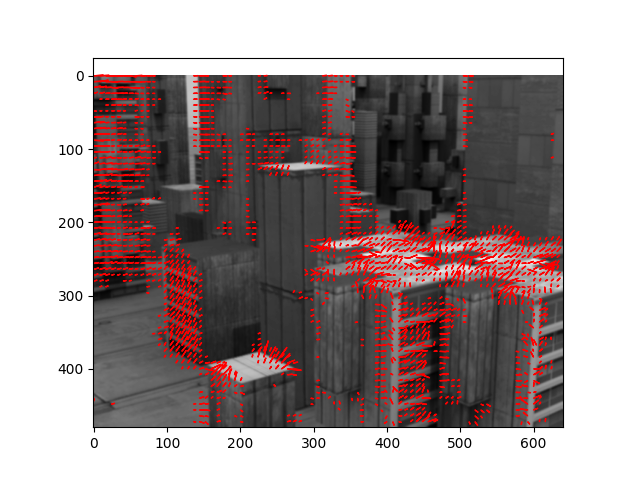

Average End-Point Error:  1.1429501593756022
Standard Deviation:  1.0812011218738857
Average Angular Error:  39.39678424199165
Standard Deviation:  22.653624638171625
Computing using:  frame08.png  and  frame09.png
derivating...
drawing...
getting magnitude...


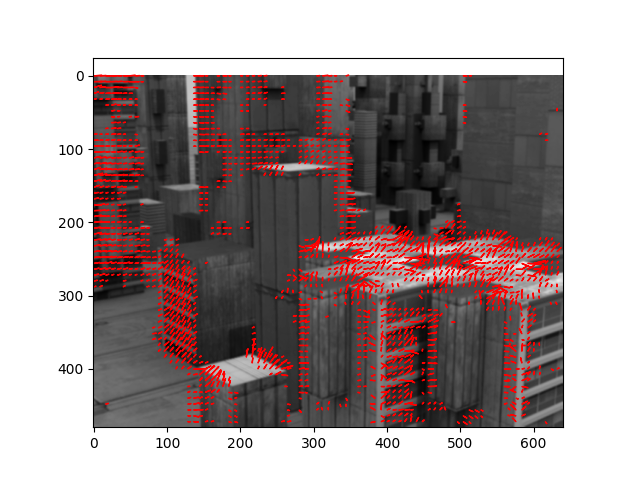

Average End-Point Error:  1.1473841598688976
Standard Deviation:  1.0452449509632258
Average Angular Error:  40.40838212988767
Standard Deviation:  21.231137481464327
Computing using:  frame09.png  and  frame10.png
derivating...
drawing...
getting magnitude...


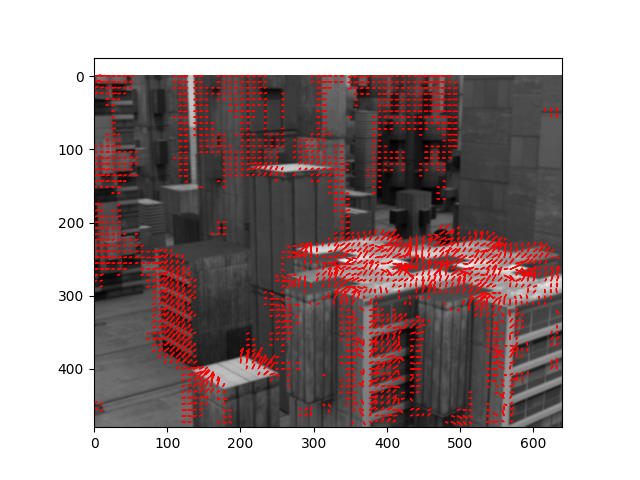

Average End-Point Error:  1.2047445746904923
Standard Deviation:  0.9974368654042023
Average Angular Error:  42.80849656184329
Standard Deviation:  20.582644565433693
Computing using:  frame10.png  and  frame11.png
derivating...
drawing...
getting magnitude...


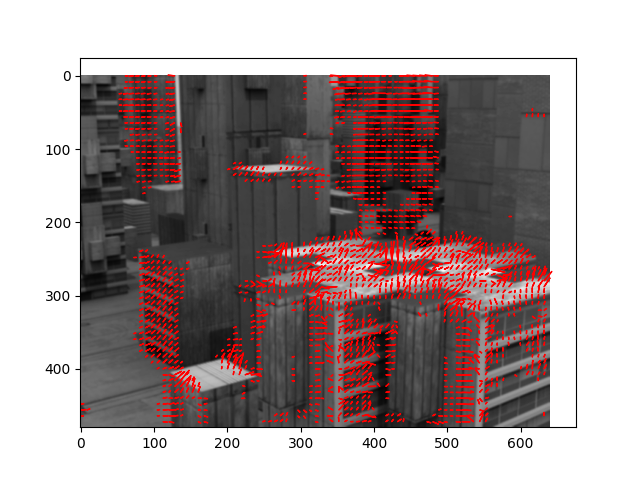

Average End-Point Error:  1.2395664176998096
Standard Deviation:  1.0656000719644667
Average Angular Error:  42.57597067973437
Standard Deviation:  21.594733714450456
Computing using:  frame11.png  and  frame12.png
derivating...
drawing...
getting magnitude...


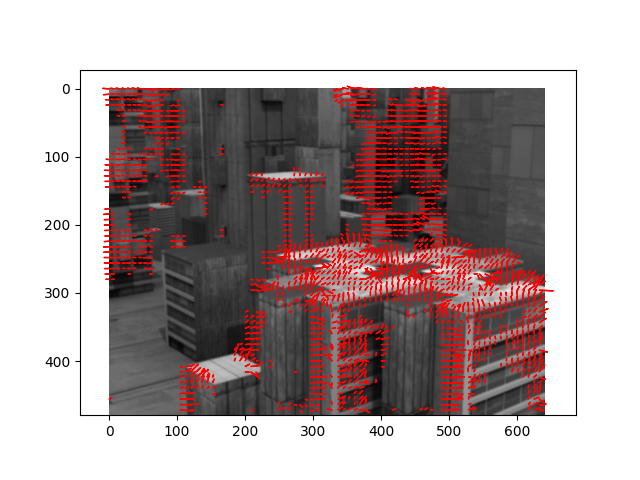

Average End-Point Error:  1.445545471073556
Standard Deviation:  1.129525753677401
Average Angular Error:  47.34931446979256
Standard Deviation:  20.757010063668485
Computing using:  frame12.png  and  frame13.png
derivating...
drawing...
getting magnitude...


C:\Users\nmcna\AppData\Local\Temp\ipykernel_15680\375867341.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = plt.figure().gca()


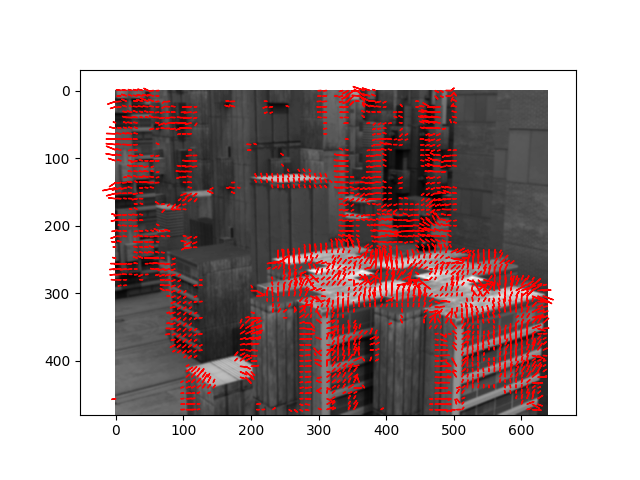

Average End-Point Error:  1.4958080365440944
Standard Deviation:  1.2132111748361651
Average Angular Error:  46.78061796234302
Standard Deviation:  22.643314104147716
Computing using:  frame13.png  and  frame14.png
derivating...
drawing...
getting magnitude...


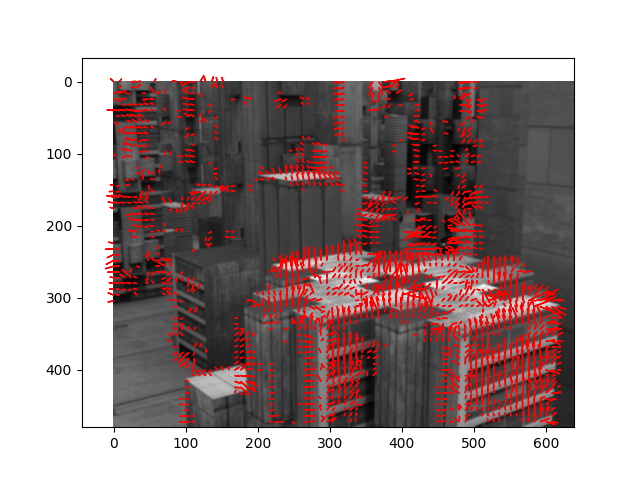

Average End-Point Error:  1.4407831308565837
Standard Deviation:  1.2768542105689167
Average Angular Error:  45.105835086379045
Standard Deviation:  22.49964272638819
MEAN AEE:  1.302397421444148
MEAN STD:  1.1155820213268945
MEAN AAE:  43.489343018853084
MEAN STD:  21.70887247053207


In [81]:
#print(f"Loading File \'config_HS.yml\'")

config = load_config('config_HS.yml')

input_path = config['input_path']

gt_path = '/Users/nmcna/Desktop/FEUP/4oano/2osemestre/VC/assignment2/dataset/other-gt-flow/Urban2/flow10.flo'

gt = read_flow_field(gt_path)

gt_u = gt[:, :, 0].astype(float) / 255.0  # Normalize u component to [0, 1]
gt_v = gt[:, :, 1].astype(float) / 255.0  # Normalize v component to [0, 1]
#name = get_frame_paths(input_path)
frames = os.listdir(input_path)
##print(frames)
aee_values = []
aee_std_values = []
aae_values = []
aae_std_values = []
for i in range(0,len(frames)-1):
    #print("CYCLE: ", i)
    u, v = computeHS(input_path, frames[i], frames[i+1], alpha=15, delta=10**-1)
    
    aee = calculate_aee(u, v, gt_u, gt_v)
    aee_std = calculate_aee_std(u, v, gt_u, gt_v)
    print("Average End-Point Error: ", aee)
    print("Standard Deviation: ", aee_std)
    aee_values.append(aee)
    aee_std_values.append(aee_std)
    
    aae = calculate_aae(u, v, gt_u, gt_v)
    aae_std = calculate_aae_std(u, v, gt_u, gt_v)
    print("Average Angular Error: ", aae)
    print("Standard Deviation: ", aae_std)
    aae_values.append(aae)
    aae_std_values.append(aae_std)
    
print("MEAN AEE: ", np.mean(aee_values))
print("MEAN STD: ", np.mean(aee_std_values))
print("MEAN AAE: ", np.mean(aae_values))
print("MEAN STD: ", np.mean(aae_std_values))


# Visualization

Done Using [flowvid](https://github.com/diegoroyo/flowvid)

In [ ]:

import flowvid
import numpy as np
from IPython.display import HTML

import flowvid as fv

flo_data = fv.input.flo('flow_field.flo')

# You can normalize by frame OR the whole video
# Normalize each flo file independently
flo_frame = fv.normalize_frame(flo_data)
# Normalize all flo files at once, applying a clamp/gamma curve
flo_video = fv.normalize_video(flo_data, clamp_pct=0.8, gamma=1.5)

# Conversion from flow data to RGB
rgb_frames = fv.flow_to_rgb(flo_video)

out5 = fv.output.show_plot(title='Flow colors', framerate=10)
out5.show_all(rgb_frames, show_count=True)





# Bench Marking


In [ ]:
import pandas as pd

def display_results():
    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['DataSet', 'Average Angular Error '])
    
    # Iterate through the function calls and store the results
    for fc in fcalls:
        # Call the function
        result = fc()
        
        # Add the function name and result to the dataframe
        results_df = results_df.append({'Function': fc.__name__, 'Result': result}, ignore_index=True)
    
    # Display the results as a markdown table
    display(results_df.to_markdown(index=False))